# Cancelaciones OTP
¿Cómo varı́a la cantidad de vuelos cancelados por mes a través de los años? ¿Está
relacionada con la magnitud de los retrasos y el OTP? ¿Se puede predecir el delay
solamente con las cancelaciones?

¿Se pueden utilizar las cancelaciones como un indicador de performance?

## Build

In [1]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.2.1
-- The CXX compiler identification is GNU 9.2.1
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/nicolas/dev/tp3/tp3/bin/python3 (found version "3.7.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.7m.so
-- pybind11 v2.4.dev4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/nicolas/dev/tp3
-- Configuring done
-- Generating done
-- Bui

## Imports

In [1]:
import predict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
def otp(dataframe, groups):
    total = dataframe.groupby(groups).size()
    delayed = dataframe[dataframe['ArrDelay']>15].groupby(groups).size()
    return delayed/total

In [3]:
def cancels(dataframe, groups):
    return dataframe[dataframe['Cancelled'] != 0].groupby(groups).size()

    

In [4]:
def nrmse(sample, predicted):
    sqErrors = (sample-predicted)*(sample-predicted)
    ymax = max(sample)
    ymin = min(sample)
    n = len(sample)
    return np.sqrt(1/n*(sum(sqErrors))) / (ymax - ymin)


## Experimentacion

Primero nos quedamos con las columnas que aporten datos sobre cancelaciones. 

In [10]:
files=[
    "1994.csv",
    "1995.csv",
    "1996.csv",
    "1997.csv",
    "1998.csv",
    "1999.csv",
    "2000.csv",
    "2001.csv",
    "2002.csv",
    "2003.csv",
    "2004.csv",
    "2005.csv",
    "2006.csv",
    "2007.csv",
    "2008.csv" 
]
root="../data/"
for f in files:
    path = root + f
    new = path + ".trimmed"
    !cut -f  1,2,15,22 -d , $path > $new

### Cancelaciones mensuales
¿Cómo varı́a la cantidad de vuelos cancelados por mes a través de los años?

In [5]:
cans = pd.Series([])
otps = pd.Series([])
files=[
    "1994.csv.trimmed",
    "1995.csv.trimmed",
    "1996.csv.trimmed",
    "1997.csv.trimmed",
    "1998.csv.trimmed",
    "1999.csv.trimmed",
    "2000.csv.trimmed",
    "2001.csv.trimmed",
    "2002.csv.trimmed",
    "2003.csv.trimmed",
    "2004.csv.trimmed",
    "2005.csv.trimmed",
    "2006.csv.trimmed",
    "2007.csv.trimmed",
    "2008.csv.trimmed" 
]
root="../data/"
for file in files:
    frame = pd.read_csv(root+file)
    monthly_cancels = cancels(frame,['Year','Month'])
    monthly_otps = otp(frame,['Year','Month'])
    cans = pd.concat([cans, monthly_cancels])
    otps = pd.concat([otps, monthly_otps])

    


Saving results to a file...

In [9]:
cans.to_csv("../data/cancellations_per_month.csv", header=False)
otps.to_csv("../data/otps_per_month.csv", header=False)

Quick overview:

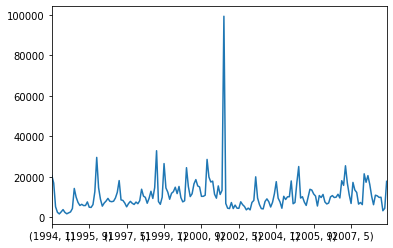

In [6]:
cans.plot()

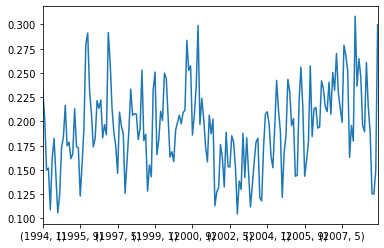

In [7]:
otps.plot()

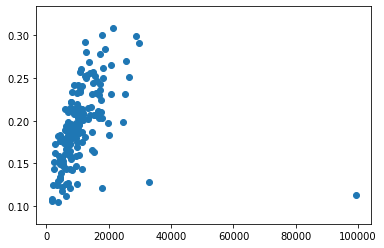

In [11]:
plt.scatter(cans, otps)

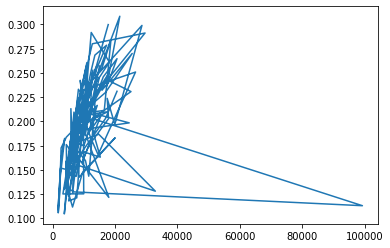

In [12]:
plt.plot(cans, otps)

### Tratamos de predecir los delays a partir de las cancelaciones

For function:  <function lineal at 0x7fe7b060bcb0>  the error was:  0.2027907054474612
For function:  <function cuadratica at 0x7fe7b060b710>  the error was:  0.1586116706466054
For function:  <function cubica at 0x7fe7b060bdd0>  the error was:  0.15048723550969245
For function:  <function grado_cuatro at 0x7fe7aff64050>  the error was:  0.15018160420828325
For function:  <function cinco at 0x7fe7aff64170>  the error was:  0.14908504870757344
For function:  <function seis at 0x7fe7aff64290>  the error was:  0.14523988692837614
For function:  <function siete at 0x7fe7aff64440>  the error was:  0.14334196710665761
For function:  <function trig at 0x7fe7aff64560>  the error was:  0.2104129992883587
For function:  <function trig2 at 0x7fe7aff64680>  the error was:  0.20248683158956013
For function:  <function trig3 at 0x7fe7aff647a0>  the error was:  0.20279069971449692
For function:  <function trig4 at 0x7fe7aff648c0>  the error was:  0.1432950169394572
0.1432950169394572


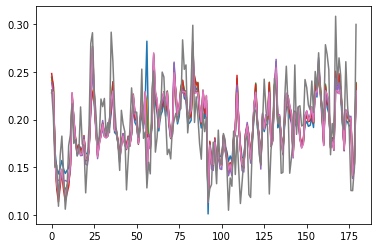

In [7]:

y = otps.to_numpy()
x = cans.to_numpy()

def lineal(x):
    return np.array([x,1])

def cuadratica(x):
    return np.array([x*x,x,1])

def cubica(x):
    return np.array([x*x*x,x*x,x,1])

def grado_cuatro(x):
    return np.array([x*x*x*x, x*x*x, x*x, x, 1])

def cinco(x):
    return np.array([x*x*x*x*x,x*x*x*x, x*x*x, x*x, x, 1])

def seis(x):
    return np.array([x*x*x*x*x*x,x*x*x*x*x,x*x*x*x, x*x*x, x*x, x, 1])

def siete(x):
    return np.array([x*x*x*x*x*x*x,x*x*x*x*x*x,x*x*x*x*x,x*x*x*x, x*x*x, x*x, x, 1])

def trig(x):
    return np.array([math.sin(x), math.cos(x), math.tan(x), x*x, 1])

def trig2(x):
    return np.array([math.sin(x), math.cos(x), x, 1])

def trig3(x):
    return np.array([math.sin(x), x, 1])

def trig4(x):
    return np.array([math.sin(x), math.cos(x), x*x*x*x*x*x*x,x*x*x*x*x*x,x*x*x*x*x,x*x*x*x, x*x*x, x*x, x, 1])


    
# Registramos funciones: (funcion, cantidad_de_coeficientes)
funcs = [
    (lineal, 2),
    (cuadratica, 3),
    (cubica,4),
    (grado_cuatro, 5),
    (cinco, 6),
    (seis, 7),
    (siete, 8),
    (trig, 5),
    (trig2, 4),
    (trig3, 3),
    (trig4, 10)
]
errs = []
for f, g in funcs:
    cml = predict.CML(f,g)
    cml.fit(x,y)
    predicted = np.array([cml.predict(e) for e in x])    
    nrmerr = nrmse(y, predicted)
    if nrmerr < 0.16:
        plt.plot(predicted)
    print("For function: ",f," the error was: ", nrmerr)
    errs.append(nrmerr)
plt.plot(y)
print(min(errs))


Polinomio de grado 7 + sen(x) + cos(x) es la mejor por ahora . Un error normalizado de 0.14 es medio grande igual no?

In [10]:
print(errs)
print(range(len(errs)))

[0.2027907054474612, 0.1586116706466054, 0.15048723550969245, 0.15018160420828325, 0.14908504870757344, 0.14523988692837614, 0.14334196710665761, 0.2104129992883587, 0.20248683158956013, 0.20279069971449692, 0.1432950169394572]
range(0, 11)
